In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

os.system("rm -rf TB")
os.system("mkdir TB")

import sys
sys.path.insert(0, "../Code/")
from train import train_eval

In [2]:
# Define the data generation process

class LowDensity():

    def __init__(self):
        pass
        
    def gen(self, n):
        n_high = np.int(np.round(0.9 * n))
        n_low = n - n_high
        x_high = np.random.uniform(size = (n_high, 2), low = 0.0, high = 0.5)
        x_low =  np.random.uniform(size = (n_low, 2), low = 0.5, high = 1.0)
        return np.vstack((x_high, x_low))
    
    def label(self, X, noise = 0.1):
        n = X.shape[0]
        y = np.zeros((n,1))
        for i in range(n):
            y[i] = 10 * ((X[i, 0] - 0.0) ** 2 + noise * np.random.normal())
        return y


In [3]:
# Define how to evaluate the learned model

def eval(sess, pred, X, n = 500):

        problem = LowDensity()
        
        # Get test accuracy
        x = problem.gen(n)
        y = problem.label(x, noise = 0.0)
        acc_noiseless = np.mean((sess.run(pred, feed_dict = {X: x}) - y)**2)
    
        # Visualize the MSE across the two dimensions
        values = np.linspace(0, 1, 100)
        grid = np.zeros((10000, 2))
        c = 0
        for i in range(100):
            for j in range(100):
                grid[c, 0] = values[i]
                grid[c, 1] = values[j]
                c += 1

        grid_pred = sess.run(pred, feed_dict = {X: grid})
        grid_y = problem.label(grid, noise = 0.0)
        grid_error = np.transpose(np.reshape(grid_pred - grid_y, (100, 100)))
        acc_grid = np.mean(grid_error ** 2)

        plt.imshow(grid_error)
        plt.title("Difference between predicted and true value")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.xlabel("Feature 0")
        plt.ylabel("Feature 1")
        plt.colorbar()
            
        plt.savefig("plots.pdf")
        plt.show()

        plt.close()

        # Evaluate whether or not the heuristic was actually enforced
        diffs = np.zeros((3))
        for i in range(10000):
            x_cur = grid[i, :]
            x_pred = sess.run(pred, feed_dict = {X: np.reshape(x_cur, (1,2))})
            
            c = 0
            
            # Evaluate invariance:  MSE of uniform perturbation with range 0.1
            x_pert = np.copy(x_cur)
            x_pert[1] += np.random.uniform(low = -0.1, high = 0.1)
            x_pred_pert = sess.run(pred, feed_dict = {X: np.reshape(x_pert, (1,2))})

            diffs[c] += (x_pred - x_pred_pert)**2
            c += 1
            
            # Evaluate monotonicity:  Average increase of value after increasing feature by 0.05
            for index in [0, 1]:
                x_pert = np.copy(x_cur)
                x_pert[index] += 0.05
                
                x_pred_pert = sess.run(pred, feed_dict = {X: np.reshape(x_pert, (1,2))})
                
                diffs[c] += x_pred_pert - x_pred
                c += 1

        diffs /= 10000

        out = {}
        out["Model MSE across noiseless samples"] = acc_noiseless
        out["Model MSE across uniform grid"] = acc_grid
        out["MSE of perturbing Feature 1"] = diffs[0]
        out["Mean Increase of increasing Feature 0"] = diffs[1]
        out["Mean Increase of increasing Feature 1"] = diffs[2]
        
        for item in out:
            print(item, ": ", out[item])

In [4]:
# Generate the dataset

problem = LowDensity()
x = problem.gen(500)
y = problem.label(x)

INFO:tensorflow:Restoring parameters from ./model.cpkt


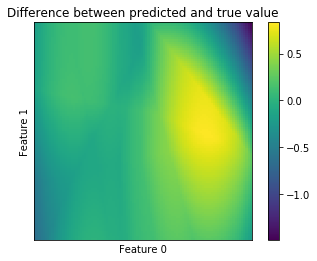

Model MSE across noiseless samples :  0.02768862162491025
Model MSE across uniform grid :  0.12355588601779355
MSE of perturbing Feature 1 :  0.005549275207519531
Mean Increase of increasing Feature 0 :  0.510931103515625
Mean Increase of increasing Feature 1 :  0.007277082061767578


In [5]:
# Train a normal model

train_eval(x, y, "regression", eval_func = eval)

INFO:tensorflow:Restoring parameters from ./model.cpkt


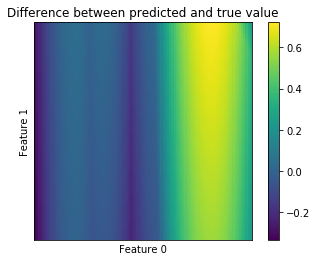

Model MSE across noiseless samples :  0.021855711033478383
Model MSE across uniform grid :  0.11594942982074033
MSE of perturbing Feature 1 :  5.086005330085755e-05
Mean Increase of increasing Feature 0 :  0.544996484375
Mean Increase of increasing Feature 1 :  -0.004919319915771485
INFO:tensorflow:Restoring parameters from ./model.cpkt


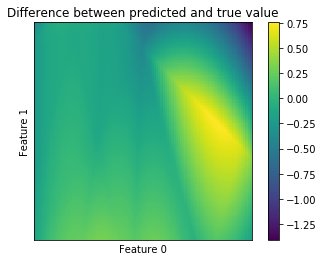

Model MSE across noiseless samples :  0.029363905872381687
Model MSE across uniform grid :  0.08093198263088582
MSE of perturbing Feature 1 :  0.00680892562866211
Mean Increase of increasing Feature 0 :  0.511660546875
Mean Increase of increasing Feature 1 :  0.027110678100585938


In [6]:
# Train a model with either an invariance or a monotonicity constraint

train_eval(x, y, "regression", eval_func = eval, heuristics = [["inv", 1, 0.1, 1000.0]])

train_eval(x, y, "regression", eval_func = eval, heuristics = [["mon", 0, 0.1, 0.1, 1.0]])


INFO:tensorflow:Restoring parameters from ./model.cpkt


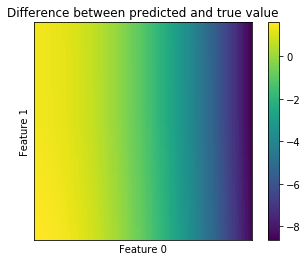

Model MSE across noiseless samples :  2.9344083071441998
Model MSE across uniform grid :  12.735526879305395
MSE of perturbing Feature 1 :  0.0002675228595733643
Mean Increase of increasing Feature 0 :  -5.626187324523926e-05
Mean Increase of increasing Feature 1 :  0.011952226257324219
INFO:tensorflow:Restoring parameters from ./model.cpkt


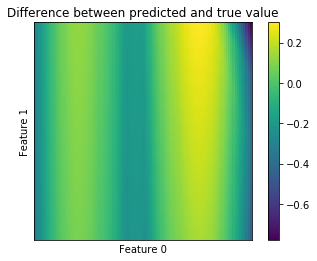

Model MSE across noiseless samples :  0.016303254249128624
Model MSE across uniform grid :  0.02632515640616197
MSE of perturbing Feature 1 :  0.00013568278551101683
Mean Increase of increasing Feature 0 :  0.503516455078125
Mean Increase of increasing Feature 1 :  -0.002388651466369629


In [7]:
# Train a model with both regularizers.  One with each direction of monotonicity constraint

train_eval(x, y, "regression", eval_func = eval, heuristics = [["mon", 0, 0.1, 1000.0, -1.0], ["inv", 1, 0.1, 1000.0]])

train_eval(x, y, "regression", eval_func = eval, heuristics = [["mon", 0, 0.1, 0.1, 1.0], ["inv", 1, 0.1, 1000.0]])